In [1]:
import importlib
import all_funcs
importlib.reload(all_funcs)
from all_funcs import *

In [2]:
import numpy as np
from skimage import io, filters, measure, morphology
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import feature, exposure, morphology, segmentation, filters
from scipy import ndimage as ndi
import matplotlib.colors as mcolors
from PIL import Image
import matplotlib.patches as mpatches


preprocess

In [9]:
threshold

32768

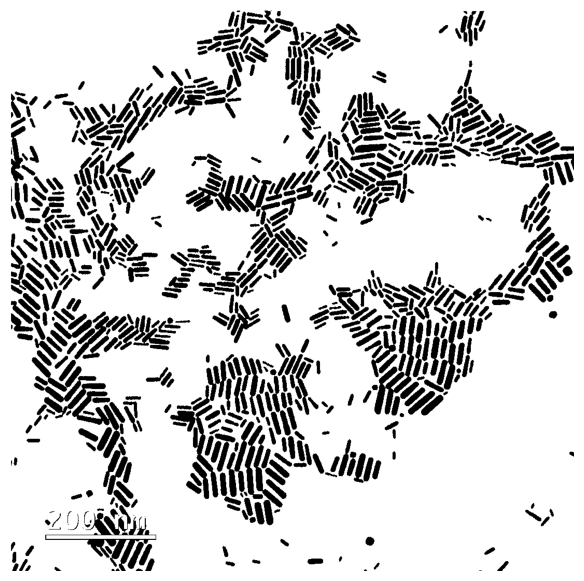

In [ ]:
from PIL import Image
import numpy as np
from skimage import filters, morphology, io, color
from skimage.measure import label
from skimage.morphology import remove_small_objects

# Step 1: Convert the image to grayscale
TEM_image_path = '/Users/joehart/Desktop/1_Imperial/Year 4/MSci project/Python_nanopores/non_python_images/nanorod_TEM.png'
TEM_image = Image.open(TEM_image_path)
TEM_image_gray = TEM_image.convert('L')  # 'L' mode is for grayscale

# Convert to numpy array for skimage processing
image_array = np.array(TEM_image_gray)

# Step 2: Apply a threshold to help remove noise and to prepare for small object removal
# Otsu's method to find the optimal threshold
threshold = filters.threshold_otsu(image_array)

# Apply threshold to create a binary image
binary_image = image_array > threshold

# Step 3: Remove small objects
# Note: adjust 'min_size' parameter as needed to remove noise while preserving your objects of interest
cleaned_image = remove_small_objects(binary_image, min_size=50) 

# Convert the binary image back to uint8 for visualization
cleaned_image_uint8 = (cleaned_image * 255).astype(np.uint8)

# Plotting the cleaned image using matplotlib
plt.figure(figsize=(6, 6))
plt.imshow(cleaned_image_uint8, cmap='gray')
plt.axis('off')
plt.tight_layout()

# Optionally, save the cleaned image to a file
# plt.savefig("MSci_python_images/TEM_image_cleaned.png", dpi=300)

plt.show()

Identified 847 objects.


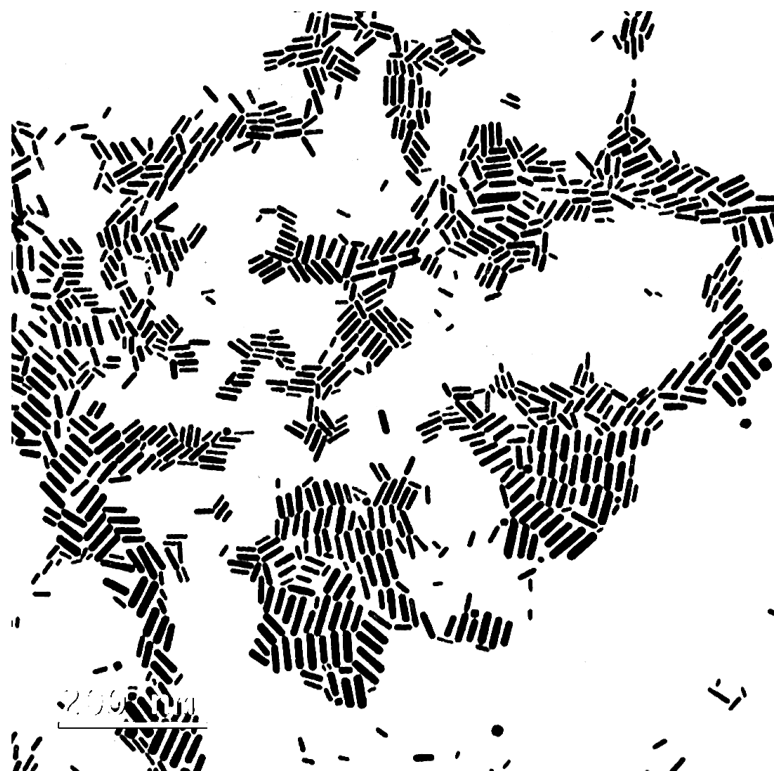

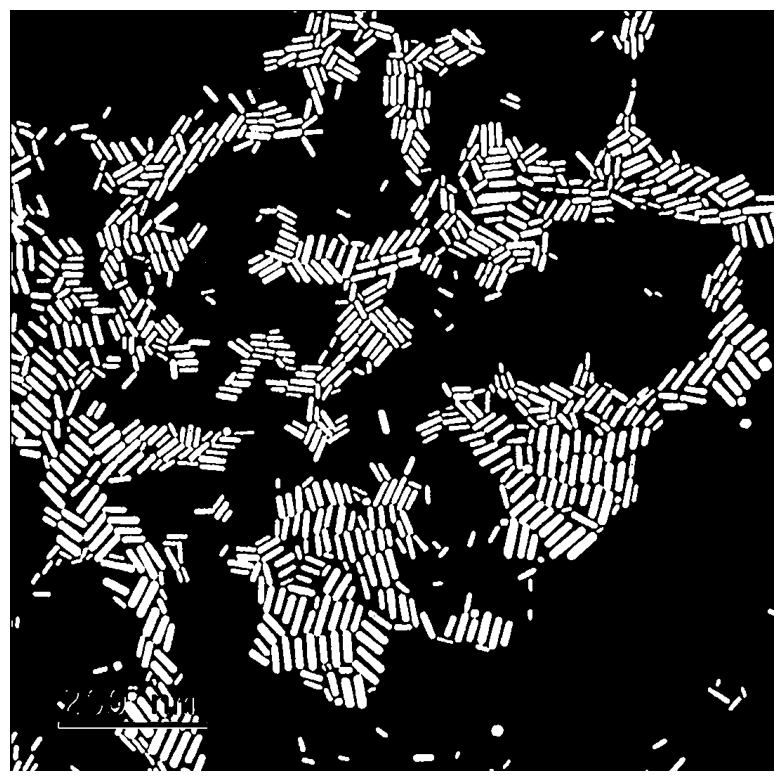

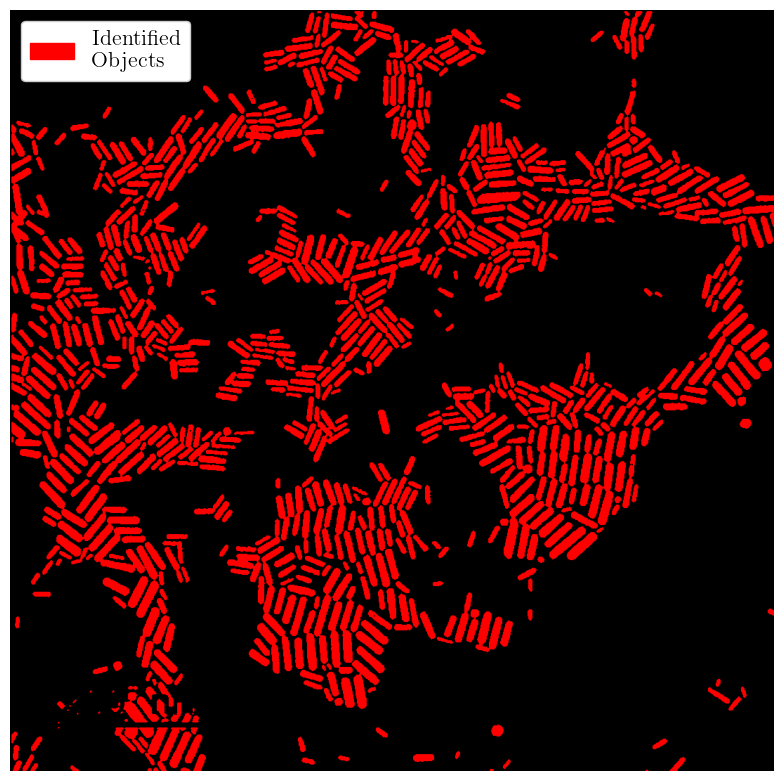

In [3]:
from skimage import io, filters, measure, morphology, color
from PIL import Image


#tem_image_pil = Image.open('non_python_images/nanorod_TEM_BW.png')
tem_image_pil = Image.open('/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/non_python_images/nanorod_TEM_BW.png')


tem_image = np.array(tem_image_pil)

# Step 1: Threshold the image to identify the rods (black)
# use a threshold to create a binary image (array of true/false or 0/1)
threshold = filters.threshold_otsu(tem_image)
binary_image = tem_image < threshold  # < as rods are black (0), background white (2^16 for this 16 bit image)

# Step 2: Remove small objects and separate touching objects
# Perform opening to remove small objects/noise
opened_image = morphology.binary_opening(binary_image, morphology.disk(1))

# Step 3: Label the image to identify individual objects (rods)
labeled_image, num_labels = measure.label(opened_image, return_num=True, connectivity=2)
print(f"Identified {num_labels} objects.")


plt.figure(figsize=(8, 8))
plt.imshow(tem_image, cmap='gray')
plt.axis('off')
plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/TEM_image_BW.png", dpi = 300)
plt.show()



plt.figure(figsize=(8, 8))
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/TEM_image_binary.png", dpi = 300)
plt.show()

# Initialize an RGB image with the same dimensions as labeled_image, filled with black (background)
rgb_image = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)

# Where labeled_image is not 0 (background), set the pixels to red [255, 0, 0]
rgb_image[labeled_image != 0] = [255, 0, 0]

# Visualization
fig, ax = plt.subplots(figsize=(8, 8))


#ax.figure(figsize=(8, 8))
ax.imshow(rgb_image)
ax.axis('off')

# Create a legend
red_patch = mpatches.Patch(color='red', label='Identified \n Objects')
legend = ax.legend(handles=[red_patch], loc='upper left', fontsize=16)
legend.get_frame().set_alpha(1)
plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/TEM_image_labeled_red.png", dpi = 300, bbox_inches='tight')

plt.show()



In [ ]:
from skimage.measure import regionprops
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

# Calculate properties of each labeled object
props = regionprops(labeled_image)

# Define minimum width and height criteria
min_width = 1
min_height = 1

# Filter objects based on width and height (using minor and major axis lengths)
filtered_props = [prop for prop in props if prop.minor_axis_length >= min_width and prop.major_axis_length >= min_height]

features_filtered = np.array([[prop.major_axis_length / prop.minor_axis_length,
                               prop.major_axis_length,
                               prop.minor_axis_length,
                               prop.eccentricity,
                               prop.solidity,
                               prop.extent] for prop in filtered_props])


scaler = StandardScaler()
features_filtered = scaler.fit_transform(features_filtered)

num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42, init= "k-means++").fit(features_filtered)
cluster_labels = kmeans.labels_

# Initialize cluster_image_filtered as a 3-channel (RGB) image
cluster_image_filtered = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)

# Define a colormap for clustering
colormap = plt.cm.nipy_spectral

# Calculate the number of objects in each cluster
cluster_counts = np.bincount(cluster_labels, minlength=num_clusters)

# Calculate the percentage of objects in each cluster
total_objects = len(cluster_labels)
cluster_percentages = (cluster_counts / total_objects) * 100

# Apply colors
for prop, cluster_label in zip(filtered_props, cluster_labels):
    color_index = 0.1 + (cluster_label + 1) / (num_clusters + 1)  # Avoid very dark colors
    rgb_color = (np.array(colormap(color_index)[:3]) * 255).astype(np.uint8)
    cluster_image_filtered[labeled_image == prop.label] = rgb_color

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(cluster_image_filtered)

plt.axis('off')

legend_handles = [
    mpatches.Patch(color=colormap(0.1 + (i + 1) / (num_clusters + 1)), label=f'Cluster {i} - {cluster_percentages[i]:.2f}$\%$')
    for i in range(num_clusters)
]
plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)

plt.tight_layout()

plt.show()


/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


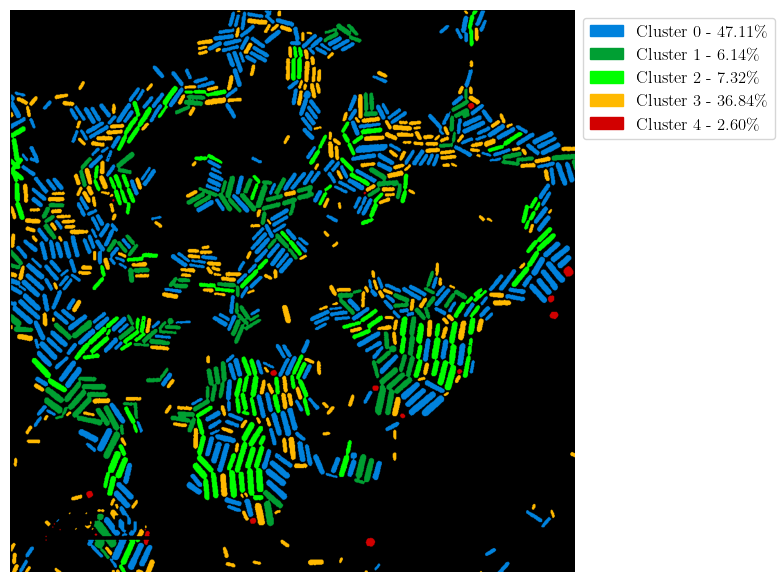

In [4]:
from skimage.measure import regionprops
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler


# Calculate properties of each labeled object
props = regionprops(labeled_image)

# Define minimum width and height criteria
min_width = 1
min_height = 1

# Filter objects based on width and height (using minor and major axis lengths)
filtered_props = [prop for prop in props if prop.minor_axis_length >= min_width and prop.major_axis_length >= min_height]

# Extract areas and aspect ratios of filtered objects
#features_filtered = np.array([(prop.area, prop.major_axis_length / prop.minor_axis_length) for prop in filtered_props])
#features_filtered = np.array([(prop.area, prop.major_axis_length,  prop.minor_axis_length, prop.major_axis_length / prop.minor_axis_length) for prop in filtered_props])
#features_filtered = np.array([(prop.area, prop.major_axis_length,  prop.minor_axis_length) for prop in filtered_props])
features_filtered = np.array([[prop.area] for prop in filtered_props])

#features_filtered = np.array([[prop.major_axis_length / prop.minor_axis_length] for prop in filtered_props])
#features_filtered = np.array([(prop.major_axis_length,  prop.major_axis_length / prop.minor_axis_length) for prop in filtered_props])
features_filtered = np.array([[prop.major_axis_length / prop.minor_axis_length,
                               prop.major_axis_length,
                               prop.minor_axis_length,
                               prop.eccentricity,
                               prop.solidity,
                               prop.extent] for prop in filtered_props])


scaler = StandardScaler()
features_filtered = scaler.fit_transform(features_filtered)

num_clusters = 5

kmeans = KMeans(n_clusters=num_clusters, random_state=42, init= "k-means++").fit(features_filtered)
cluster_labels = kmeans.labels_

# Initialize cluster_image_filtered as a 3-channel (RGB) image
cluster_image_filtered = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)

# Define a colormap and adjust the range to avoid black for visibility
colormap = plt.cm.nipy_spectral

# Calculate the number of objects in each cluster
cluster_counts = np.bincount(cluster_labels, minlength=num_clusters)

# Calculate the percentage of objects in each cluster
total_objects = len(cluster_labels)
cluster_percentages = (cluster_counts / total_objects) * 100

# Apply colors and calculate percentages
for prop, cluster_label in zip(filtered_props, cluster_labels):
    color_index = 0.1 + (cluster_label + 1) / (num_clusters + 1)  # Avoid very dark colors
    rgb_color = (np.array(colormap(color_index)[:3]) * 255).astype(np.uint8)
    cluster_image_filtered[labeled_image == prop.label] = rgb_color

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(cluster_image_filtered)

plt.axis('off')

# Adjusting the legend to include percentage population
legend_handles = [
    mpatches.Patch(color=colormap(0.1 + (i + 1) / (num_clusters + 1)), label=f'Cluster {i} - {cluster_percentages[i]:.2f}$\%$')
    for i in range(num_clusters)
]
plt.legend(handles=legend_handles, bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
#plt.legend(handles=legend_handles, fontsize=10, loc='upper left')

plt.tight_layout()
#plt.savefig("MSci_python_images/TEM_image_clustering_5_spheres.png", dpi = 300, bbox_inches='tight')

plt.show()


Rod length and width

In [5]:
major_lengths = np.array([prop.major_axis_length for prop in filtered_props])
minor_lengths = np.array([prop.minor_axis_length for prop in filtered_props])

# 200 nm = 212 pixels --> 1 nm = 1.06 pixels --> 1 pixel = 0.94 nm
pixel_to_nm_ratio = 200/212



print(f"average rod length = {np.mean(major_lengths * pixel_to_nm_ratio)} $\pm$ {np.std(major_lengths * pixel_to_nm_ratio / np.sqrt(len(major_lengths)))}")
print(f"average rod width = {np.mean(minor_lengths * pixel_to_nm_ratio)} $\pm$ {np.std(minor_lengths * pixel_to_nm_ratio / np.sqrt(len(minor_lengths)))}")

average rod length = 34.56698591922833 $\pm$ 0.7789753329228501
average rod width = 9.67948935840613 $\pm$ 0.2114986617214204


In [6]:
min_length = 100
for maj, min in zip(pixel_to_nm_ratio*major_lengths,pixel_to_nm_ratio*minor_lengths):
    if maj < min_length and maj/min >= 3:
        min_length = maj

print(f"min particle length = {min_length}")


min particle length = 7.1314051511174945


Proportion of rods with length < pore opening size

In [7]:
major_lengths_nm = major_lengths * pixel_to_nm_ratio

In [13]:
major_lengths_nm

array([ 6.3409, 29.3183, 11.2374, ...,  6.1007,  5.9666,  3.6129])

In [22]:
major_lengths_nm_less_pore = major_lengths_nm[(major_lengths_nm > 15) & (major_lengths_nm < 25)]


In [23]:
print(f"proportion = {len(major_lengths_nm_less_pore) / len(major_lengths)}")

proportion = 0.24557260920897284


excluding spheres

/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


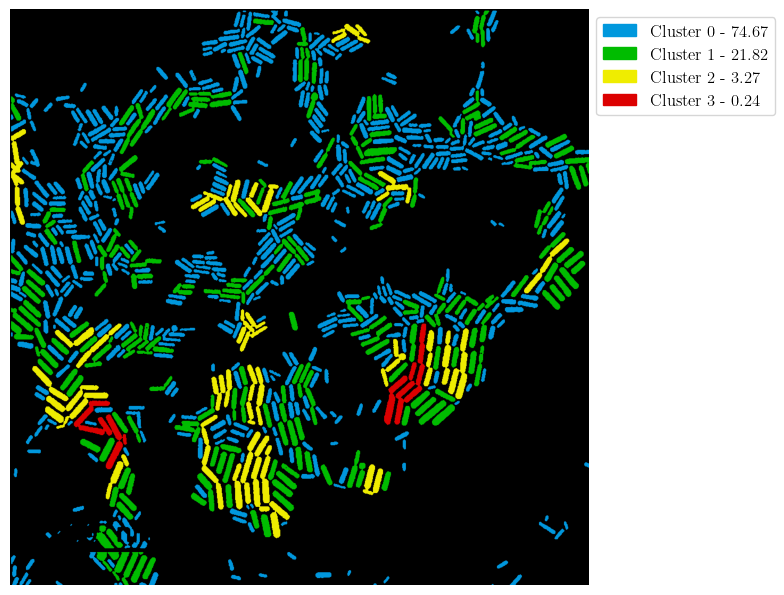

In [8]:
indices_to_exclude = np.where(cluster_labels == 4)[0]  # exclude cluster 4 (spheres)

features_filtered_excluded = np.delete(features_filtered, indices_to_exclude, axis=0)
filtered_props_excluded = [prop for i, prop in enumerate(filtered_props) if i not in indices_to_exclude]
areas = np.array([prop.area for prop in filtered_props]).reshape(-1, 1)
areas_excluded = np.delete(areas, indices_to_exclude, axis=0)


num_clusters_filtered = 4
#kmeans_filtered = KMeans(n_clusters=num_clusters_filtered, random_state=42, init="k-means++").fit(features_filtered_excluded)
kmeans_filtered = KMeans(n_clusters=num_clusters_filtered, random_state=42, init="k-means++").fit(areas_excluded)


# Now, cluster_labels_filtered contains the labels from the new clustering
cluster_labels_filtered = kmeans_filtered.labels_

# Initialize cluster_image_filtered as a 3-channel (RGB) image
cluster_image_filtered_new = np.zeros((*labeled_image.shape, 3), dtype=np.uint8)

# Use the same colormap
colormap = plt.cm.nipy_spectral

# Calculate the new number of objects and their distribution in clusters after filtering
new_num_clusters = np.max(cluster_labels_filtered) + 1  # Adjust based on your clustering results
new_cluster_counts = np.bincount(cluster_labels_filtered, minlength=new_num_clusters)

# Calculate the new percentages
new_total_objects = len(cluster_labels_filtered)
new_cluster_percentages = (new_cluster_counts / new_total_objects) * 100

# Reapply colors and calculate new percentages for the visualization
# Make sure to iterate over the filtered properties list
for prop, cluster_label in zip(filtered_props_excluded, cluster_labels_filtered):
    color_index = 0.1 + (cluster_label + 1) / (new_num_clusters + 1)  # Adjust color assignment
    rgb_color = (np.array(colormap(color_index)[:3]) * 255).astype(np.uint8)
    cluster_image_filtered_new[labeled_image == prop.label] = rgb_color

# Visualization of the new clustering results
plt.figure(figsize=(8, 8))
plt.imshow(cluster_image_filtered_new)
plt.axis('off')

# Adjusting the legend to include new percentage population
legend_handles_new = [
    mpatches.Patch(color=colormap(0.1 + (i + 1) / (new_num_clusters + 1)), label=f'Cluster {i} - {new_cluster_percentages[i]:.2f}%')
    for i in range(new_num_clusters)
]
plt.legend(handles=legend_handles_new, bbox_to_anchor=(1, 1), loc='upper left', fontsize=12)
plt.tight_layout()
#plt.savefig("MSci_python_images/TEM_image_clustering_5_nospheres.png", dpi = 300, bbox_inches='tight')

plt.show()


/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/joehart/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init

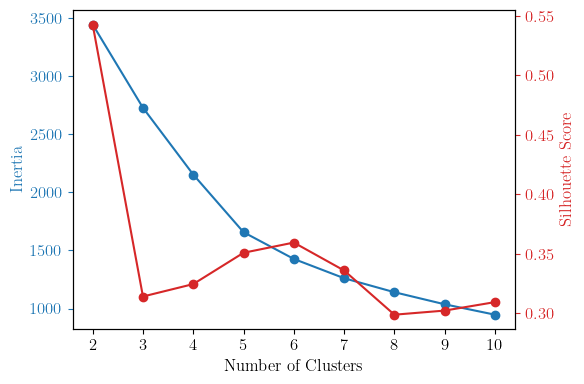

In [5]:
num_clusters_range = range(2, 11)  # Silhouette score is not defined for n_clusters = 1

# DataFrame to store results
results_df = pd.DataFrame(columns=["Num_Clusters", "Inertia", "Silhouette_Score"])


for n_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, init="k-means++")
    kmeans.fit(features_filtered)
    
    labels = kmeans.labels_
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(features_filtered, labels)
    
    results_df.loc[n_clusters-1] = [n_clusters, inertia, silhouette_avg]

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4))

color = 'tab:blue'
ax1.plot(results_df["Num_Clusters"], results_df["Inertia"], color=color, marker='o', label='Inertia')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.tick_params('y', colors=color)
ax1.set_xticks(list(range(2, 21)))  # Adjust based on your num_clusters_range

color = 'tab:red'
ax2 = ax1.twinx()
ax2.plot(results_df["Num_Clusters"], results_df["Silhouette_Score"], color=color, marker='o', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color=color)
ax2.tick_params('y', colors=color)

fig.tight_layout()
plt.show()

In [116]:
filtered_props[0]

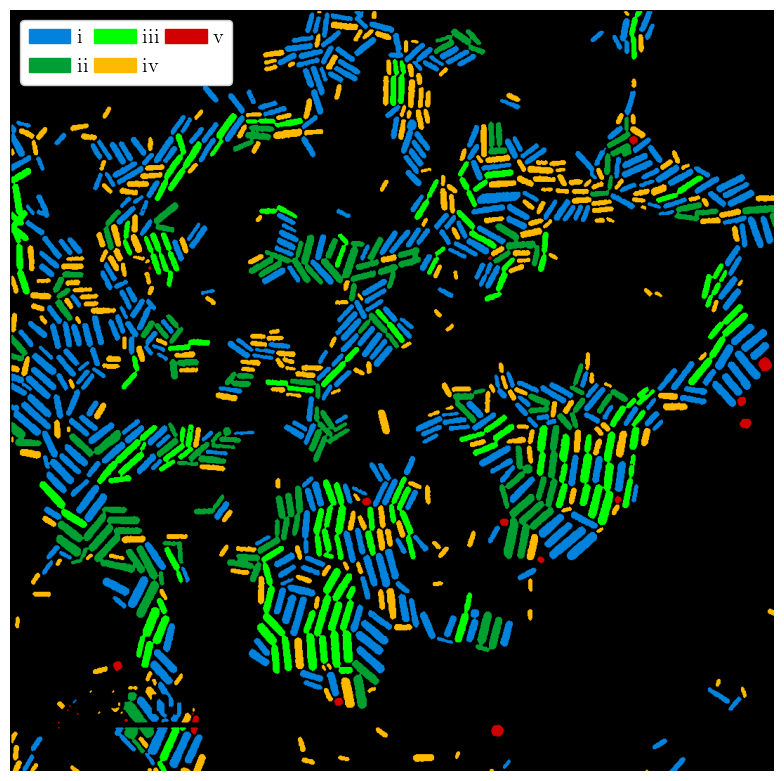

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figsize as needed to match your data's aspect ratio
ax.imshow(cluster_image_filtered)
ax.axis('off')

clusters_labels = ["i", "ii", "iii", "iv", "v"]

# Adjusting the legend to include percentage population
legend_handles =[
    mpatches.Patch(color=colormap(0.1 + (i + 1) / (num_clusters+1)), label=f'{clusters_labels[i]} ({cluster_percentages[i]:.2f}$\%$)')
    for i in range(num_clusters)
]
#legend = ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title="Clusters")
legend_handles =[
    mpatches.Patch(color=colormap(0.1 + (i + 1) / (num_clusters+1)), label=clusters_labels[i])
    for i in range(num_clusters)
]
legend = ax.legend(handles=legend_handles, loc='upper left', fontsize=15, ncols =3, columnspacing = 0.3, handletextpad=0.3)
legend.get_frame().set_alpha(1)


plt.setp(legend.get_title(), fontsize='14')  # Adjust legend title font size

plt.tight_layout()
# If saving the figure, adjust parameters to minimize whitespace
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/TEM_image_clustering_spheres.png", dpi=300, bbox_inches='tight')

plt.show()

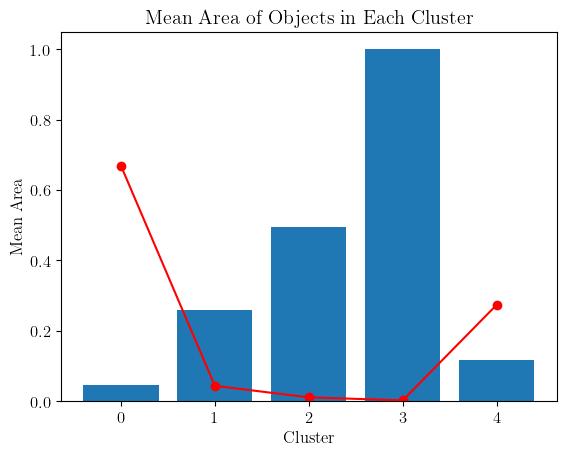

In [22]:

cluster_areas = {i: [] for i in range(num_clusters)}


for prop, label in zip(filtered_props_excluded, cluster_labels_filtered):
    cluster_areas[label].append(prop.area)

mean_areas = {cluster: np.mean(areas) for cluster, areas in cluster_areas.items()}
mean_areas_norm = {cluster: np.mean(areas) / np.max(list(mean_areas.values())) for cluster, areas in cluster_areas.items()}


# Visualize the mean area for each cluster
plt.bar(range(num_clusters), mean_areas_norm.values())
plt.plot(range(num_clusters), new_cluster_percentages/100, 'ro-')
plt.xlabel('Cluster')
plt.ylabel('Mean Area')
plt.title('Mean Area of Objects in Each Cluster')
plt.show()


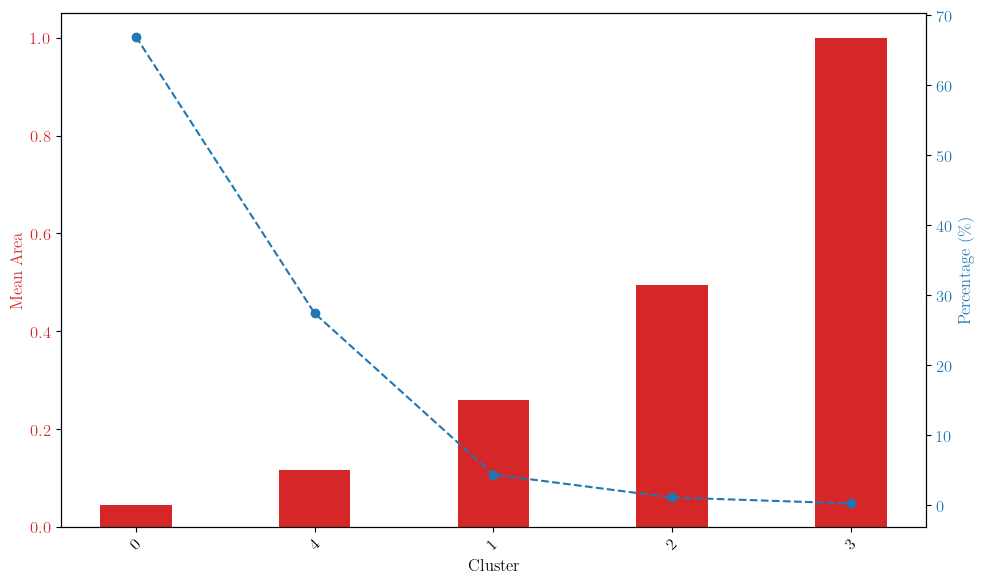

In [26]:
sorted_indices = np.argsort(-new_cluster_percentages)
sorted_percentages = new_cluster_percentages[sorted_indices]
sorted_means = [mean_areas_norm[i] for i in sorted_indices]
sorted_labels = np.array(cluster_labels)[sorted_indices]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for mean area values
color = 'tab:red'
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Mean Area', color=color)
ax1.bar(np.arange(len(sorted_means)), sorted_means, width=0.4, color=color, label='Mean Area')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(np.arange(len(sorted_indices)))
ax1.set_xticklabels(sorted_indices, rotation=45)

# Create a second y-axis for the percentage values
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Percentage ($\%$)', color=color)
ax2.plot(np.arange(len(sorted_percentages)), sorted_percentages, color=color, label='Percentage', marker='o', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
#plt.savefig("MSci_python_images/TEM_image_cluster_mean_area_pop_nospheres.png", dpi = 300)
plt.show()

### SVM visual

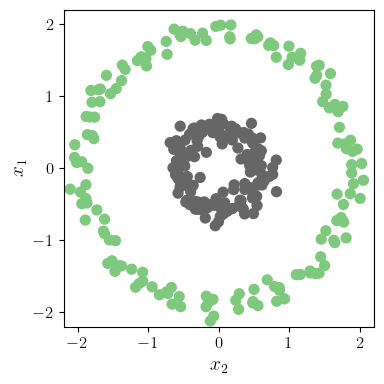

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler
from sklearn import svm
scaler = StandardScaler()


X3, y3 = make_circles(noise=0.05, factor=0.3, random_state=42, n_samples=300)

# Standardize features
X3_scaled = scaler.fit_transform(X3)

# SVM model for the 2D non-linear decision boundary (with RBF kernel) for visually appealing data
clf4 = svm.SVC(kernel='rbf', C=1)
clf4.fit(X3_scaled, y3)

# 1st Graph: 2D decision boundary for the visually appealing dataset
xx, yy = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))
Z3 = clf4.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z3 = Z3.reshape(xx.shape)

# 1st Graph: 2D scatter plot of the scaled features
plt.figure(figsize=(4, 4))
plt.scatter(X3_scaled[:, 0], X3_scaled[:, 1], c=y3, s=50, cmap='Accent')
plt.xlabel("$x_2$", fontsize = 14)
plt.ylabel("$x_1$", fontsize = 14)
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
plt.xticks(np.arange(-2, 3, 1))
plt.yticks(np.arange(-2, 3, 1))
plt.tight_layout()
#plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/svm_visual_1.png", dpi=300)

plt.show()


In [75]:
%matplotlib inline

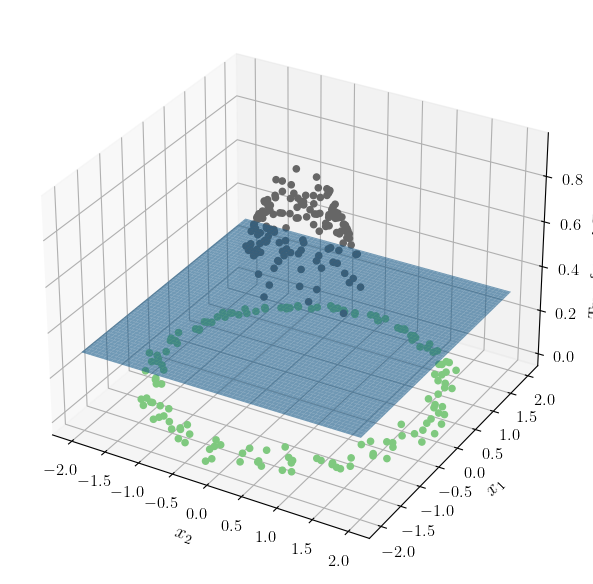

In [9]:
X3_3D = np.vstack((X3_scaled.T, np.exp(-(X3_scaled ** 2).sum(1)))).T
clf5 = svm.SVC(kernel='linear').fit(X3_3D, y3)
coef, intercept = clf5.coef_.ravel(), clf5.intercept_

zz = (-coef[0] * xx - coef[1] * yy - intercept) * 1. / coef[2]

# 2nd Graph: 3D visualization with the hyperplane
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, rstride=8, cstride=8, alpha=0.6)
ax.scatter(X3_3D[:, 0], X3_3D[:, 1], X3_3D[:, 2], c=y3, cmap='Accent', alpha  =1)

plt.xlabel("$x_2$", fontsize = 14)
plt.ylabel("$x_1$", fontsize = 14)
#set number of x ticks\

plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
ax.set_zlabel('Transformed Feature')
plt.tight_layout()
plt.show()

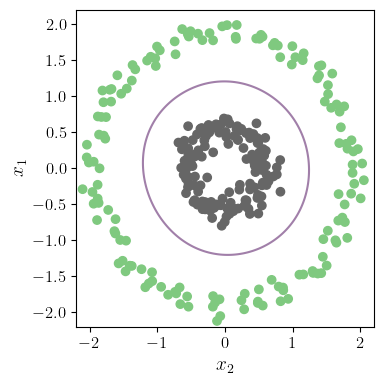

In [10]:
Z4 = clf5.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z4 = Z4.reshape(xx.shape)
# 3rd Graph: Decision boundary back in 2D
plt.figure(figsize=(4, 4))
plt.contour(xx, yy, Z3, levels=[0], alpha=0.5, linestyles='-')
plt.scatter(X3_scaled[:, 0], X3_scaled[:, 1], c=y3, cmap='Accent')
plt.xlabel("$x_2$", fontsize = 14)
plt.ylabel("$x_1$", fontsize = 14)
plt.xlim(-2.2, 2.2)
plt.ylim(-2.2, 2.2)
plt.tight_layout()
plt.savefig("/Users/joehart/Desktop/chemistry/Year 4/MSci project/Python_nanopores/MSci_python_images/svm_visual_3.png", dpi=300)
plt.show()

### Wavlet scalogram visual

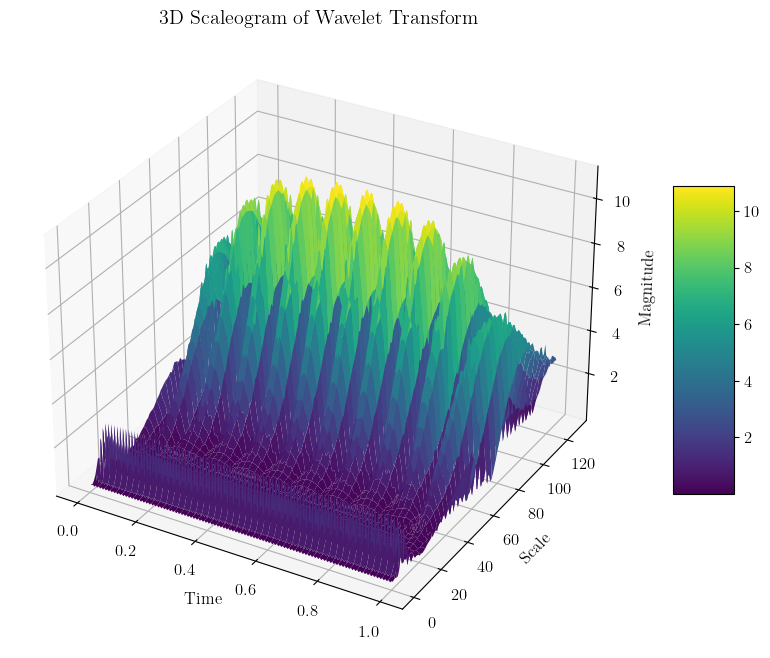

In [19]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

t = np.linspace(0, 1, num=500, endpoint=False)  # Time array
signal = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 50 * t)  # Signal: combination of two sine waves

scales = np.arange(1, 128)
wavelet = 'morl'  # Morlet wavelet
coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1.0 / 500)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
T, S = np.meshgrid(t, scales)

# Surface plot
surf = ax.plot_surface(T, S, np.abs(coefficients), cmap='viridis', edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

ax.set_xlabel('Time')
ax.set_ylabel('Scale')
ax.set_zlabel('Magnitude')
ax.set_title('3D Scaleogram of Wavelet Transform')
plt.show()
